$$d_{\pm} = \frac{\log(Se^{rT}/K)}{\sigma \sqrt{T - t}} \pm \frac{(\sigma \sqrt{T - t})^{2}}{2}$$

$$K[\frac{S}{Ke^{-rT}} \Phi(d_{+}) - \Phi(d_{-})]$$

$$\frac{S_{T}}{K} = \exp(\log(S_{t}/K) - 0.5 \sigma^{2}(T - t) + \sigma \sqrt{T - t}Z)$$


$$d_{\pm} = \frac{\log(F_{t}/K)}{\sigma \sqrt{T - t}} \pm \frac{(\sigma \sqrt{T - t})}{2}$$


$$K [\frac{F_{t}}{K}\Phi(d_{+}) - \Phi(d_{-})] = F_{t}[\Phi(d_{+}) - \frac{K}{F_{t}}\Phi(d_{-})]$$


$$F_{t}\mathbb{E}^{\mathbb{Q}}[(1 - \frac{K}{F_{T}})^{+} | F_{t}/K, \sigma \sqrt{T - t}]$$


$$d_{-} > 0$$

In [25]:
%run key_imports.py

(131072, 2) (131072,)


<AxesSubplot:>

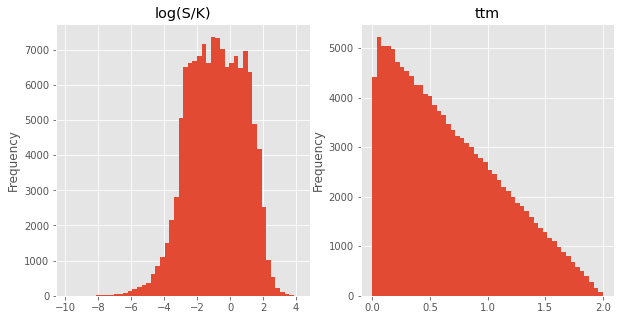

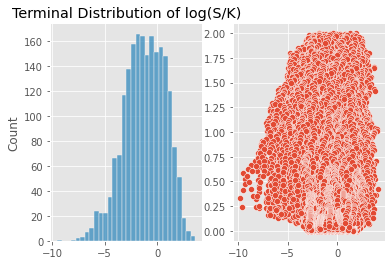

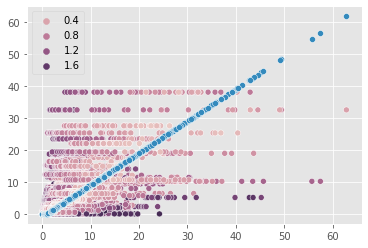

In [53]:
"""
Fix Random Seed
"""
SEED = 42
rng = default_rng(SEED)

"""
Fix Terminal maturity
"""

T = 1
N_TIMES = 64
dt = T / N_TIMES
ts = np.linspace(0, T, N_TIMES + 1)

"""
Define State Variables
"""
N_SAMPLES = 2048
SKs = rng.uniform(-3, 2, N_SAMPLES) # log-moneyness
sigma = rng.uniform(1e-6, 2, N_SAMPLES) # volatilty


"""
Define Brownian Increments
"""
W = rng.standard_normal((N_SAMPLES, N_TIMES)) * np.sqrt(dt)


"""
Simulate St, Vt paths
"""
Sts = np.zeros((N_SAMPLES, N_TIMES + 1))
Sts[:, 0] = SKs

def gbm_step(F, dt, sigma, Z):
    return F - (0.5 * (sigma ** 2) * dt) + sigma * Z

for i in range(N_TIMES):
    Sts[:,i + 1] = gbm_step(Sts[:,i], dt, sigma, W[:,i])

"""
Combine to create dataset
"""

feat_names = ['log(S/K)', 'ttm']
f_to_i = lambda x: feat_names.index(x)

# Fix terminal payoff, go forward in time
y = np.maximum(np.exp(Sts[:,-1]) - 1, 0)
Xs = np.vstack([Sts[:, :-1].reshape(-1),
                (sigma.reshape((-1, 1)) * np.sqrt(T - ts[:-1])).reshape(-1)
                ]).T
ys = np.repeat(y, N_TIMES)
X_df = pd.DataFrame(Xs, columns = feat_names)


print(Xs.shape, ys.shape)
assert Xs.shape[0] == ys.shape[0]

"""
Visualise data
"""
# Distributions
fig, ax = plt.subplots(figsize=(5 * X_df.shape[1], 5), ncols = X_df.shape[1])
for i in range(X_df.shape[1]):
    X_df.iloc[:, i].plot(kind = 'hist', ax = ax[i], bins = 50)
    ax[i].set_title(feat_names[i])
    
fig, ax = plt.subplots(ncols = 2)
sns.scatterplot(x = Xs[:, f_to_i("log(S/K)")], y = Xs[:, f_to_i("ttm")], ax = ax[1])
sns.histplot(Sts[:, -1], ax = ax[0])
ax[0].set_title("Terminal Distribution of log(S/K)")
ax[1].set_title("")
# sample payoff, intrinsic val v S/K
fig, ax = plt.subplots()
intrinsic_val = np.maximum(np.exp(Xs[:,f_to_i("log(S/K)")]) - 1.0, 0)
sns.scatterplot(x = np.exp(Xs[:,f_to_i("log(S/K)")]), y = ys, hue = Xs[:, f_to_i("ttm")])
sns.scatterplot(x = np.exp(Xs[:,f_to_i("log(S/K)")]), y = intrinsic_val)

In [1]:
!ls

American.ipynb                RoughVol.ipynb
BSComplete.ipynb              SABR.ipynb
Basket.ipynb                  SLV.ipynb
DeepHedgingBlackScholes.ipynb Untitled.ipynb
DeepHedgingHeston.ipynb       __pycache__
DeepHedgingInLattice.ipynb    bs.py
DeepHedgingRoughBergomi.ipynb heston.py
DeepLearningExam.ipynb        heston_dataset.csv
Generator_Test.ipynb          key_imports.py
Heston.ipynb                  sabr.py
JuliaFluxNeuralPDE.jl         untitled.py
NeuralPDE.ipynb               utils.py


In [62]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from nn_archi import make_model

ModuleNotFoundError: No module named 'nn_archi'

In [57]:
HIDDEN_UNITS = 4096
LAYERS = 1
dropout_ratio = 0.0
HIDDEN_ACT = 'softplus'
N_FEATS = 2
OUTPUT_ACT = 'softplus'
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 30
BATCH_NORM = False

loss_fn = tf.keras.losses.MeanSquaredError()
opt = Adam(learning_rate = LR)
ffn = make_model(N_FEATS, 
                 HIDDEN_UNITS, 
                 LAYERS, 
                 DROPOUT_RATIO, 
                 HIDDEN_ACT, 
                 OUTPUT_ACT, 
                 BATCH_NORM)


ffn.compile(optimizer=opt, loss=loss_fn)
print(np.mean((y - y.mean()) ** 2))
print(np.mean(np.abs(y - y.mean())))
history = ffn.fit(X2, y, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = 0.1,
                  shuffle=True,
                  callbacks=[EarlyStopping(patience=5)])

NameError: name 'make_model' is not defined

In [232]:
loss_fn = tf.keras.losses.MeanAbsoluteError()
opt = Adam(learning_rate = LR)
ffn = make_model(N_FEATS, 
                 HIDDEN_UNITS, 
                 LAYERS, 
                 DROPOUT_RATIO, 
                 HIDDEN_ACT, 
                 OUTPUT_ACT, 
                 BATCH_NORM)

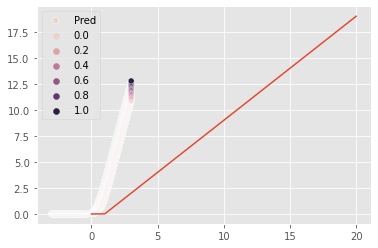

In [52]:
SK_space = np.linspace(0, 20, 100)
preds = ffn.predict(X).reshape(-1)
sns.lineplot(x = np.log(SK_space, y = european_put(SK_space).numpy())
sns.scatterplot(x = X[:,0], y = preds, hue = X[:,1], label = "Pred")
plt.legend()

<AxesSubplot:>

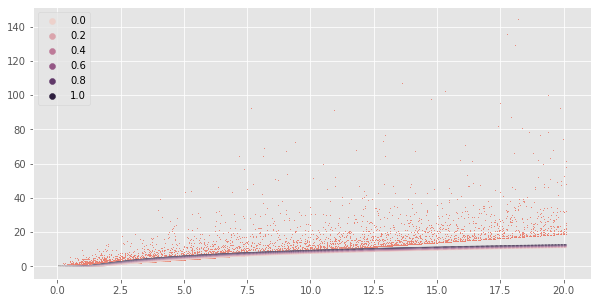

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x = np.exp(X[:,0]), y = y, s=1)
sns.scatterplot(x = np.exp(X[:,0]), y = preds, hue = X[:,1], s=1)

Epoch 1/30
26/26 [==============================] - 1s 17ms/step - loss: 0.1535 - val_loss: 1.5831e-09
Epoch 2/30
26/26 [==============================] - 0s 13ms/step - loss: 0.1096 - val_loss: 4.1443e-08
Epoch 3/30
26/26 [==============================] - 0s 12ms/step - loss: 0.1042 - val_loss: 1.9514e-07
Epoch 4/30
26/26 [==============================] - 0s 13ms/step - loss: 0.1034 - val_loss: 2.7775e-07
Epoch 5/30
26/26 [==============================] - 0s 13ms/step - loss: 0.1021 - val_loss: 8.2993e-08
Epoch 6/30
26/26 [==============================] - 0s 14ms/step - loss: 0.1037 - val_loss: 6.0671e-08
0.520904541015625


<AxesSubplot:>

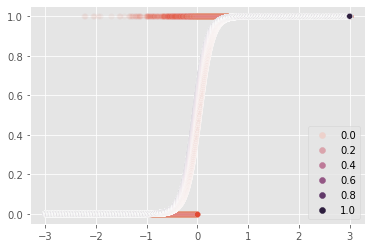

In [18]:
HIDDEN_UNITS = 4096
LAYERS = 1
dropout_ratio = 0.0
HIDDEN_ACT = 'relu'
N_FEATS = 2
OUTPUT_ACT = 'sigmoid'
DROPOUT_RATIO = 0.0
LR = 1e-2
BATCH_SIZE = 1024
EPOCHS = 30
BATCH_NORM = False


opt = Adam(learning_rate = LR)
ffn = make_model(N_FEATS, 
                 HIDDEN_UNITS, 
                 LAYERS, 
                 DROPOUT_RATIO, 
                 HIDDEN_ACT, 
                 OUTPUT_ACT, 
                 BATCH_NORM)



loss_fn = tf.keras.losses.BinaryCrossentropy()
ffn.compile(optimizer=opt, loss=loss_fn)
history = ffn.fit(X, y > 0, 
                  epochs = EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_split = 0.2, 
                  callbacks=[EarlyStopping(patience=5)])

print(np.mean((y >0) ** 2))
preds = ffn.predict(X).reshape(-1)
sns.scatterplot(x = X[:,0], y = (y > 0), alpha=0.05)
sns.scatterplot(x = X[:,0], y = preds, hue = X[:,1])

/var/folders/gg/bdgg0c0n28x14l2hd83rbx3c0000gn/T/ipykernel_5636/1984918900.py:3: RuntimeWarning: divide by zero encountered in true_divide
  true_digital = norm.cdf((X[:,0] / X[:,1]) - 0.5 * X[:,1])
/var/folders/gg/bdgg0c0n28x14l2hd83rbx3c0000gn/T/ipykernel_5636/1984918900.py:4: RuntimeWarning: divide by zero encountered in true_divide
  true_pdf = norm.pdf((X[:,0] /  X[:,1]) - 0.5 * X[:,1])


<AxesSubplot:>

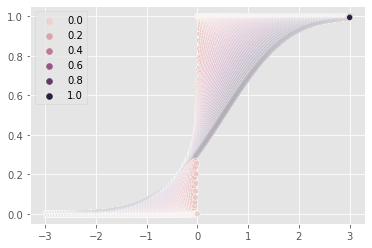

In [19]:
from scipy.stats import norm

true_digital = norm.cdf((X[:,0] / X[:,1]) - 0.5 * X[:,1])
true_pdf = norm.pdf((X[:,0] /  X[:,1]) - 0.5 * X[:,1])
sns.scatterplot(x = X[:,0], y = true_digital, hue = X[:,1])

In [22]:
def diagnosis(true, pred):
    return {"l1": np.mean(np.abs(true - pred)),
            "l2": np.sqrt(np.mean((true -pred) ** 2)),
            "linf": np.max(np.abs(true - pred)),
           }

diagnosis(true_digital, preds)

{'l1': 0.05151252560585344,
 'l2': 0.11266705372123159,
 'linf': 0.5552756190299988}

<AxesSubplot:>

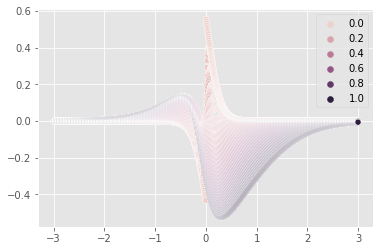

In [24]:
sns.scatterplot(x = X[:,0], y = true_digital - preds, hue = X[:,1])

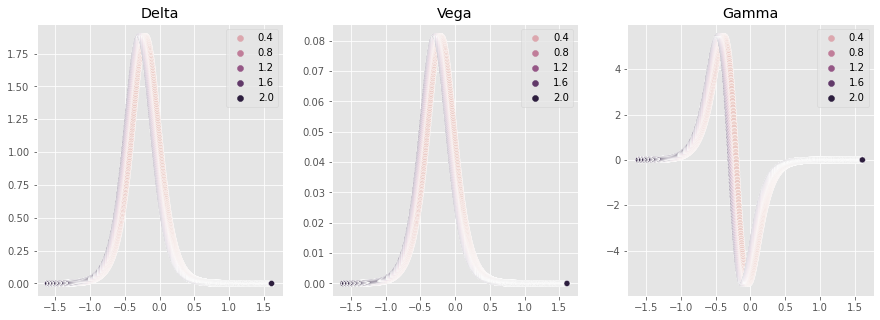

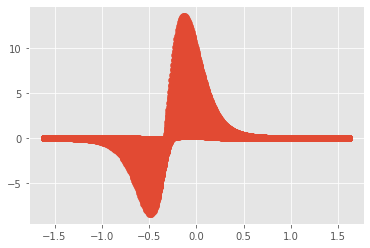

In [238]:
fig, ax = plt.subplots(ncols = 3, figsize=(15, 5))

X_tensor = tf.Variable(X)
hessians = [None for i in range(X.shape[1])]
for i in range(X.shape[1]):  
    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape:
            output = ffn(X_tensor)
            grads = tape.gradient(output, X_tensor)
            tape2.watch(grads)
            hessians[i] = tape2.gradient(grads[:,i], X_tensor)

delta = grads.numpy()[:,0]
vega = grads.numpy()[:,1]
gamma = hessians[0].numpy()[:,0]
            
sns.scatterplot(x = X[:,0], y = delta, hue = X[:, 1], ax  =ax[0])
sns.scatterplot(x = X[:,0], y = vega, hue = X[:,1], ax = ax[1])
sns.scatterplot(x = X[:,0], y = gamma, hue = X[:, 1], ax = ax[2])

for i, x in enumerate(["Delta", "Vega", "Gamma"]):
    ax[i].set_title(x)
    
error = vega - X[:,1] * (gamma - delta)
fig, ax = plt.subplots()
plt.scatter(X[:,0], error)

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


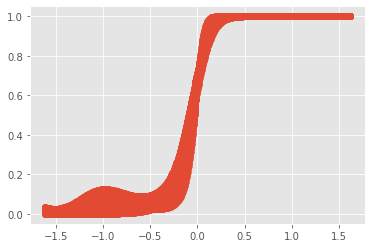

In [239]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
X2 = PolynomialFeatures(degree=5).fit_transform(X)

reg = LinearRegression(fit_intercept=False).fit(X2, y)
logit_reg = LogisticRegression(fit_intercept=False).fit(X2, (y > 0))
plt.scatter(X[:,0], logit_reg.predict_proba(X2)[:,1])

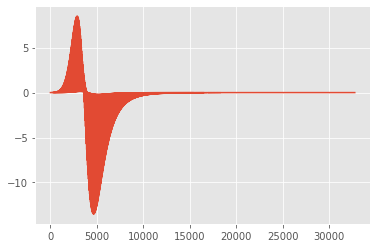

In [240]:
plt.plot(X[:,1] * (gamma - delta))

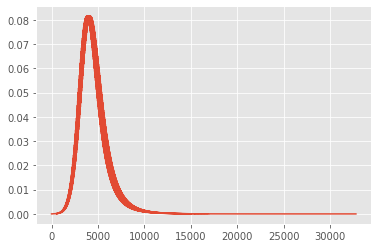

In [241]:
plt.plot(vega)

In [242]:


def rbf(x):
    return tf.math.exp(-0.5 * x ** 2)
    
input_moneyness = Input(1)
input_ttm = Input(1)
x1 = Dense(1, activation='sigmoid', kernel_constraint='non_neg')(input_ttm)
x2 = Dense(1, activation=rbf, kernel_constraint='non_neg')(input_moneyness)
# x3 = Dense(1, activation='softplus', kernel_constraint='non_neg')(input_moneyness)
# x4 = Multiply()([x2, x3])
x = Multiply()([x1, x2])
# x2 = Dense(1, activation='exponential', name='intrinsic')(input_layer)
# x3 = Lambda(lambda x: tf.keras.activations.relu(x - 1))(x2)
# x = Dense(32, activation='softplus', kernel_constraint='non_neg')(x)
# x = Dense(32, activation='softplus', kernel_constraint='non_neg')(x)
# output_layer = Add()([x3, Dense(1, activation='softplus')(x)])
output_layer = Dense(1, kernel_constraint='non_neg', use_bias=False)(x)
model = Model([input_moneyness, input_ttm], output_layer)
# model.layers

# model.layers[1].trainable = False
# model.layers[1].set_weights([np.array([[1], [0]]), np.array([0.0])])

In [243]:
model.predict([X[:,0], X[:,1]])

array([[0.2169367 ],
       [0.22261785],
       [0.22828712],
       ...,
       [0.35428008],
       [0.35747427],
       [0.36055693]], dtype=float32)

In [656]:
intrinsic_value = np.maximum(np.exp(X[:,0]) - 1.0, 0)
model.compile(loss='MSE', optimizer='Adam', loss_weights = (intrinsic_value < y) * 1.0)
model.fit([X[:,0], X[:,1]], y - intrinsic_value, epochs=10)

Epoch 1/10
258/258 [==============================] - 1s 1ms/step - loss: 0.0172
Epoch 2/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 3/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 4/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 5/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 6/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 7/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 8/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 9/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 10/10
258/258 [==============================] - 0s 1ms/step - loss: 0.0146


0.0


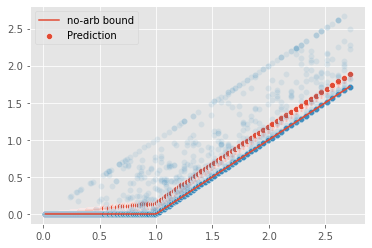

In [657]:
preds = model.predict([X[:,0], X[:,1]]).reshape(-1) + intrinsic_value
sns.scatterplot(x = np.exp(X[:, 0]), y = preds, label="Prediction")
sns.scatterplot(x = np.exp(X[:, 0]), y = y.clip(0, np.exp(X[:,0])), alpha = 0.1)
intrinsic_val = np.maximum(np.exp(X[:, 0]) - 1.0, 0)
sns.lineplot(x = np.exp(X[:, 0]), y = intrinsic_val, label = "no-arb bound")

print(np.mean(preds < intrinsic_val))

In [122]:
X_tensor = tf.Variable(X)
hessians = [None for i in range(X.shape[1])]
for i in range(X.shape[1]):  
    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape:
            output = model([X_tensor[:,0], X_tensor[:,1]])
            grads = tape.gradient(output, X_tensor)
        hessians[i] = tape2.gradient(grads[:,i], X_tensor)

ValueError: Layer "model_11" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(4096,), dtype=float64, numpy=array([-3., -3., -3., ...,  3.,  3.,  3.])>, <tf.Tensor: shape=(4096,), dtype=float64, numpy=
array([0.        , 0.03225806, 0.06451613, ..., 0.93548387, 0.96774194,
       1.        ])>]

$\frac{\partial \log(S/K)}{\partial s} = \frac{1}{s}, \frac{\partial \log(S/K)}{\partial s} = \frac{-1}{K}$

$V_{x} \frac{\partial x}{\partial s}$

<AxesSubplot:>

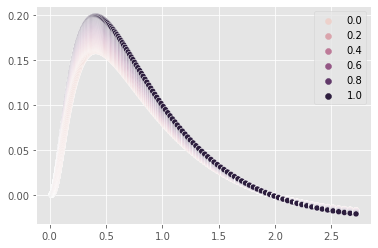

In [670]:
sns.scatterplot(x = np.exp(X[:,0]), y = np.exp(-X[:,0]) * grads[:,0], hue=X[:,1])

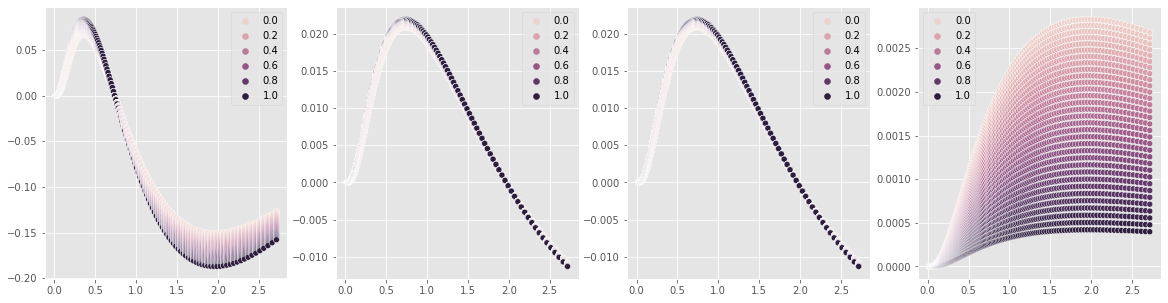

In [671]:
fig, ax = plt.subplots(figsize=(4 * 5, 5), ncols = 4)
for i in range(4):
    sns.scatterplot(x = np.exp(X[:,0]), y = hessians[i // 2][:, i % 2], hue=X[:,1], ax = ax[i])

$$V_{t} + rsV_{s} + \frac{s^{2}V_{ss}\sigma^{2}}{2} - rV = 0$$

$x = \log(S/K), \frac{\partial x}{\partial s} = \frac{1}{s}, \frac{\partial^{2}x}{\partial s^{2}} = \frac{-1}{s^{2}}$

$$V_{\sigma \sqrt{T - t}}\frac{\sigma}{2\sqrt{T - t}} + rsV_{x}\frac{\partial x}{\partial s} + \frac{s^{2}\sigma^{2}}{2}[V_{xx} (\frac{\partial x}{\partial s})^{2} + V_{x} \frac{\partial^{2} x}{\partial s^{2}}] - rV = 0$$

$$V_{\sigma \sqrt{T - t}}\frac{\sigma}{2\sqrt{T - t}} + rsV_{x}\frac{\partial x}{\partial s} + \frac{s^{2}\sigma^{2}}{2}[V_{xx} (\frac{\partial x}{\partial s})^{2} + V_{x} \frac{\partial^{2} x}{\partial s^{2}}] - rV = 0$$

$$-V_{\sigma}\sqrt{T - t} \frac{\sigma}{2\sqrt{T - t}} + (r - \frac{\sigma^{2}}{2})V_{x} + \frac{\sigma^{2}V_{xx}}{2} -rV = 0$$


$$\frac{-V_{\sigma}\sqrt{T - t}}{\sigma \sqrt{T - t}} + (\frac{r}{2\sigma^{2}} - 1)V_{x} + V_{xx} -\frac{r}{2\sigma^{2}}V = 0$$

In [639]:
error = grads[:,1] - X[:,1] * ((hessian[:, 0] + (r / (0.5 * sigma ** 2) - 1) * grads[:,0] - (r / (0.5 * sigma ** 2))))

<AxesSubplot:>

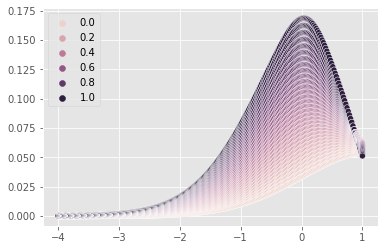

In [640]:
sns.scatterplot(x = X[:,0], y = error, hue = X[:,1])

<AxesSubplot:ylabel='Count'>

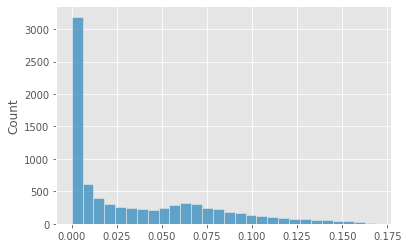

In [641]:
sns.histplot(error)

In [642]:
S0 = 1
SK = np.linspace(-2, 3, 128) 
K = np.exp(-SK) / S0

ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))

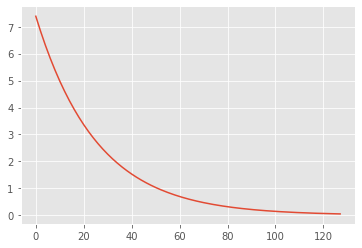

In [643]:
plt.plot(np.exp(-SK))

In [644]:
preds = model(X).numpy().reshape(-1) + np.maximum(X[:,0] - 1.0, 0)
sns.lineplot(x = np.exp(-X[:,0]), y = preds, hue = X[:, 1])
preds



ValueError: Layer "model_56" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor: shape=(16384, 2), dtype=float64, numpy=
array([[-2.        ,  0.        ],
       [-2.        ,  0.03149606],
       [-2.        ,  0.06299213],
       ...,
       [ 3.        ,  3.93700787],
       [ 3.        ,  3.96850394],
       [ 3.        ,  4.        ]])>]

In [645]:

preds

ValueError: cannot reshape array of size 8256 into shape (128,newaxis)

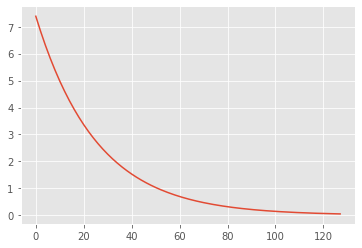

In [646]:
plt.plot(K)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

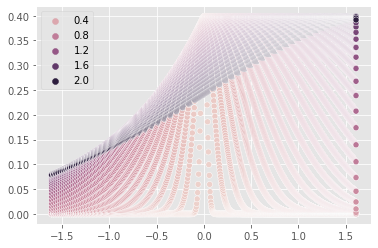

In [221]:
sns.scatterplot(X[:,0], true_pdf, hue = X[:,1])

In [227]:
np.sum(true_pdf[::N_TIME] * np.diff(SKs)[0])

0.15459622507239681

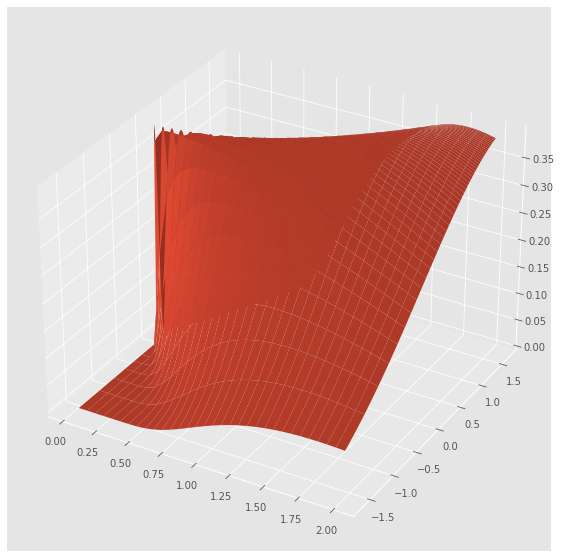

In [218]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

a,b = np.meshgrid(sigma_ts, SKs)
preds = true_pdf.reshape((SKs.shape[0], sigma_ts.shape[0]))
ax.plot_surface(a, b, preds)

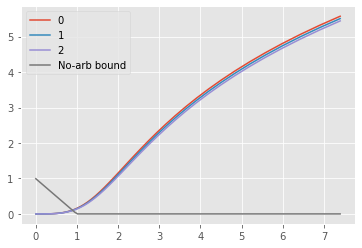

In [107]:
N_POINTS = 100
test_case = np.zeros((N_POINTS, 2))

for i in [0, 1, 2]:
    test_case[:, 1] = i
    test_case[:,0] = np.linspace(-5, 2, N_POINTS)

    preds = ffn.predict(test_case).reshape(-1)
    plt.plot(np.exp(test_case[:,0]), preds, label = f"{i}")
    
plt.plot(np.exp(test_case[:,0]), np.maximum(1.0 - np.exp(test_case[:,0]), 0), label='No-arb bound')
plt.legend()

In [191]:
def BS(SK, sigma_tau):
    return np.exp(SK) * norm.cdf((SK / sigma_tau) + 0.5 * sigma_tau) - norm.cdf((SK / sigma_tau) - 0.5 * sigma_tau)

<AxesSubplot:>

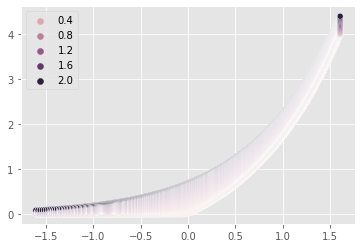

In [244]:
sns.scatterplot(x = X[:,0], y = BS(X[:,0], X[:,1]), hue=X[:,1])

+ https://github.com/DovaX/artificial-neural-networks-in-option-pricing/blob/master/Artifical%20Neural%20Networks%20in%20Option%20Pricing.pdf
